In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [2]:
df_listings = pd.read_csv('C:/Users/ryanv/OneDrive/Desktop/Seattle_airbnb_data/listings.csv')

In [3]:
df_listings.shape

(3818, 92)

## Business and Data Understanding

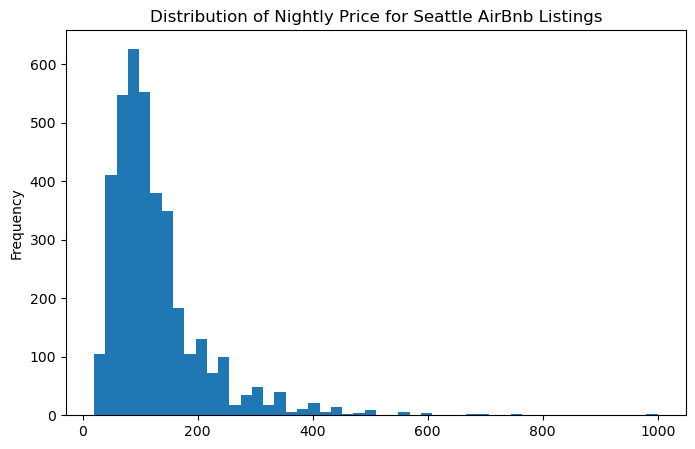

In [20]:
#visualize the distribtion of nightly price / target variable

#df_listings.price.hist(bins=100);
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
df_listings.price.plot(kind = "hist", bins=50)
plt.title("Distribution of Nightly Price for Seattle AirBnb Listings")
plt.show()

## Data Preparation

In [5]:
# Retrieve the creation date of the dataframe for feature engineering
df_listing_last_scraped = pd.Timestamp(df_listings.at[0,'last_scraped'])

# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns with only one unique value
df_listings.drop([c for c in df_listings.columns if df_listings[c].nunique()==1],axis=1,inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Reformat the money related columns
df_listings.price = df_listings.price.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.weekly_price = df_listings.weekly_price.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.monthly_price = df_listings.monthly_price.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.security_deposit = df_listings.security_deposit.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.cleaning_fee = df_listings.cleaning_fee.str.replace(r"$","").str.replace(",","").astype("float32");
df_listings.extra_people = df_listings.extra_people.str.replace(r"$","").str.replace(",","").astype("float32");

# Transform the date related columns
df_listings['host_since_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.host_since)).dt.days
df_listings['last_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.last_review)).dt.days
df_listings['first_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.first_review)).dt.days


# Reformat other features
df_listings['host_response_time'] = df_listings.host_response_time.map({"within an hour":1,"within a few hours":12,\
                                                                        "within a day":24,"a few days or more":48})
df_listings.host_response_rate = df_listings.host_response_rate.str.replace("%","").astype("float32")
df_listings['cancellation_policy'] = df_listings['cancellation_policy'].map({'strict':0,'moderate':1,'flexible':2})

# Create a feature count the number of host verification methods
host_verifications = np.unique(np.concatenate(df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", "))))[1:]
matrix_verifications=[[veri in row for row in df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", ")) ] for veri in host_verifications]
df_listings['host_verificationCount'] = pd.DataFrame(matrix_verifications,index=host_verifications).T.sum(1)

In [6]:
df_listings.shape

(3818, 76)

In [7]:
def add_target_columns(df_listings):
    """
    This function adds the target columns Estimated_bookings and Estimated_monthly_revenue to the dataframe.
    
    Parameters:
    df_listings : Dataframe of listings data
    
    Returns:
    df_listings : Dataframe of listings data with added target columns
    
    """
    df_listings['Estimated_bookings'] = df_listings.reviews_per_month.astype('float') * .50
    df_listings['Estimated_monthly_revenue'] = df_listings['Estimated_bookings'] * df_listings['price']
    
    return df_listings
    

In [8]:
df_listings = add_target_columns(df_listings)

In [9]:
#Manually filter the dataset for relevant features

features_host = ['host_is_superhost','host_about','host_response_time','host_response_rate', 'host_listings_count',
                 'host_verificationCount','host_has_profile_pic','host_identity_verified','host_since_deltaDays',\
                 'calculated_host_listings_count']

features_property = ['summary','space','description','neighborhood_overview','notes','transit',
                     'street','neighbourhood','zipcode','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','square_feet','price','weekly_price','security_deposit','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']

features_traveler = ['number_of_reviews','last_review_deltaDays','first_review_deltaDays','review_scores_rating',
                     'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                     'review_scores_location','review_scores_value','instant_bookable','cancellation_policy',\
                     'require_guest_profile_picture','require_guest_phone_verification','reviews_per_month']

features = features_host + features_property + features_traveler + ['Estimated_bookings', 'Estimated_monthly_revenue']
df_listings_filtered = df_listings[features]

In [10]:
#Prepare features for machine learning model by converting to the correct data types

numeric_feature = ['host_listings_count','calculated_host_listings_count','latitude','longitude','accommodates','bathrooms',
                   'bedrooms','beds','guests_included','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating',
                   'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                   'review_scores_location','review_scores_value', 'review_scores_rating' ,'review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                   'review_scores_value' ,'reviews_per_month'] 

bool_feature = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
                'require_guest_phone_verification','require_guest_profile_picture']

# Transform the bool features
for bool_f in bool_feature:
    df_listings_filtered[bool_f] = df_listings_filtered[bool_f].map({'t':1,'f':0}).astype('bool')

# Transform the numerical features
for num_f in numeric_feature:
    df_listings_filtered[num_f] = df_listings_filtered[num_f].astype("float32")

In [11]:
# Fix the weird zipcode value
df_listings_filtered.zipcode[df_listings_filtered.zipcode=="99\n98122"] = 98122
# Drop column square_feet for containing too many NA values (97.5%)
df_listings_filtered.square_feet.isna().mean()
df_listings_filtered.drop("square_feet",axis=1,inplace=True)

In [12]:
#Get list of unique amenities to one hot encode into model inputs

unique_amenities = np.unique(np.concatenate(df_listings_filtered.amenities.str[1:-1].str.replace('"','')
                                            .str.split(",")))[1:]
print(unique_amenities)

['24-Hour Check-in' 'Air Conditioning' 'Breakfast'
 'Buzzer/Wireless Intercom' 'Cable TV' 'Carbon Monoxide Detector' 'Cat(s)'
 'Dog(s)' 'Doorman' 'Dryer' 'Elevator in Building' 'Essentials'
 'Family/Kid Friendly' 'Fire Extinguisher' 'First Aid Kit'
 'Free Parking on Premises' 'Gym' 'Hair Dryer' 'Hangers' 'Heating'
 'Hot Tub' 'Indoor Fireplace' 'Internet' 'Iron' 'Kitchen'
 'Laptop Friendly Workspace' 'Lock on Bedroom Door' 'Other pet(s)'
 'Pets Allowed' 'Pets live on this property' 'Pool' 'Safety Card'
 'Shampoo' 'Smoke Detector' 'Smoking Allowed' 'Suitable for Events' 'TV'
 'Washer' 'Washer / Dryer' 'Wheelchair Accessible' 'Wireless Internet']


In [13]:
matrix_amenities=[[amen in row for row in df_listings_filtered.amenities.str[1:-1].str.replace('"','').
                   str.split(",") ] for amen in unique_amenities]
df_amenities = pd.DataFrame(matrix_amenities,index=unique_amenities).T

# Drop amenities features appear in less than 5% of samples to avoid overfitting
df_amenities.drop(df_amenities.columns.values[np.where(df_amenities.mean()<0.05)],axis=1,inplace=True)
df_listings_filtered_amenities = pd.concat([df_listings_filtered,df_amenities],axis=1)

In [14]:
#Calculate and view the percantage of null values for each column

print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))

security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
Estimated_bookings             0.164222
last_review_deltaDays          0.164222
reviews_per_month              0.164222
first_review_deltaDays         0.164222
Estimated_monthly_revenue      0.164222
space                          0.149031
host_response_rate             0.136983
host_response_time             0.136983
neighbourhood                  0.108958
summary                        0.046359
bathrooms                      0.004191


In [15]:
df_listings_filtered_amenities_cleaned = df_listings_filtered_amenities.copy()

# Fill NA for numeric features
df_listings_filtered_amenities_cleaned.zipcode = df_listings_filtered_amenities_cleaned.zipcode.fillna(
                                                df_listings_filtered_amenities_cleaned.zipcode.mode()[0])
feature_fillna_median = ['host_response_time','host_response_rate','security_deposit','cleaning_fee','weekly_price','bedrooms',
                         'bathrooms','review_scores_rating','review_scores_communication','review_scores_cleanliness','review_scores_location',
                         'review_scores_value','review_scores_accuracy','review_scores_checkin', 'beds', 'host_listings_count',
                         'host_since_deltaDays', 'last_review_deltaDays', 'first_review_deltaDays', 'reviews_per_month'
                        ]
df_listings_filtered_amenities_cleaned[feature_fillna_median] = df_listings_filtered_amenities_cleaned[feature_fillna_median].fillna(
                                                                df_listings_filtered_amenities_cleaned[feature_fillna_median].median())

# Fill NA for object features
feature_fillna_empty =  ['summary','neighbourhood','space','host_about','transit','neighborhood_overview','notes']
df_listings_filtered_amenities_cleaned[feature_fillna_empty] = df_listings_filtered_amenities_cleaned[feature_fillna_empty].fillna('')

# Numerical features
df_num = df_listings_filtered_amenities_cleaned.select_dtypes(exclude='object')
# One hot encoding categorical features
df_cat = pd.get_dummies(df_listings_filtered_amenities_cleaned.select_dtypes(include='object')[['property_type','room_type', 'bed_type']])
# Drop one hot categorical feature columns appearing less then 5% of samples
catFeatureToDrop = df_cat.columns.where(df_cat.mean()<0.05).dropna()
df_cat.drop(catFeatureToDrop,axis=1,inplace=True)
df_cat = df_cat.astype("bool")
df_total = pd.concat([df_num,df_cat],axis=1)




## Data Modeling

In [16]:
# Fit ridge regression model for predicting price

X = df_total.drop(['weekly_price','price','Estimated_bookings','Estimated_monthly_revenue'],axis=1)
y = df_total.price
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.595


## Evaluate the results

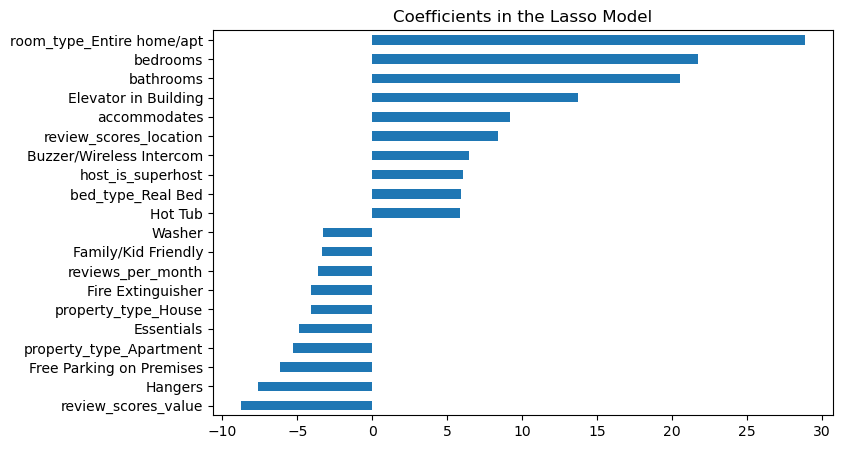

In [17]:
# Visualize coefficient of the ridge regression model

coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## Data Modeling Part 2

In [18]:
# Fit ridge regression model for predicting monthly revenue

df_total = df_total[df_total['Estimated_monthly_revenue'].notna()]

X = df_total.drop(['weekly_price','price','Estimated_bookings','reviews_per_month','Estimated_monthly_revenue'],axis=1)
y = df_total.Estimated_monthly_revenue
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.476


## Evaluate the Results

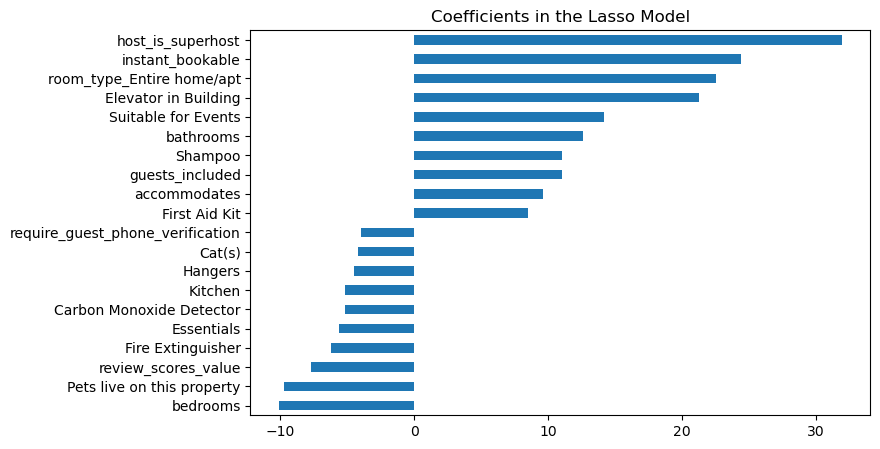

In [19]:
# Visualize coefficient of the ridge regression model

coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()